In [3]:
import cv2
import numpy as np

def count_scars(image):
    '''
    # Convert to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    # Apply threshold to binarize the image
    _, binary = cv2.threshold(gray, 128, 255, cv2.THRESH_BINARY_INV)
    # Find contours
    contours, _ = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    # Count the number of contours (scars)
    scar_count = len(contours)
    '''

    # Convert image to HSV color space for better color segmentation
    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

    # Define color range for detecting brown scars
    lower_brown = np.array([10, 100, 20])
    upper_brown = np.array([20, 255, 200])

    # Create a mask for brown color
    mask = cv2.inRange(hsv, lower_brown, upper_brown)

    # Bitwise-AND mask and original image to keep only the brown parts (scars)
    scar_result = cv2.bitwise_and(image, image, mask=mask)

    # Find contours in the mask (scars)
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Count the number of contours (scars)
    scar_count = len(contours)

    return scar_count, contours

def calculate_area(contours):
    # Calculate area of the contours
    area = sum([cv2.contourArea(cnt) for cnt in contours])
    return area

def calculate_percentage_damage(lamina_area, scar_area):
    # Calculate percentage damage
    percentage_damage = (scar_area / lamina_area) * 100
    return percentage_damage

def find_lamina_and_petioles(image):
    # Convert to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    # Apply threshold to binarize the image
    _, binary = cv2.threshold(gray, 128, 255, cv2.THRESH_BINARY_INV)
    # Find contours
    contours, _ = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    # Assuming the largest contour is the lamina, and second largest is the petiole
    contours = sorted(contours, key=cv2.contourArea, reverse=True)
    lamina_contour = contours[0]
    petiole_contour = contours[1] if len(contours) > 1 else None
    return lamina_contour, petiole_contour

def main(image_path):
    # Load the image
    image = cv2.imread(image_path)

    # Find lamina and petiole contours
    lamina_contour, petiole_contour = find_lamina_and_petioles(image)

    # Determine lamina area
    lamina_area = calculate_area([lamina_contour])

    # Count scars and calculate scar area
    scar_count, scar_contours = count_scars(image)
    scar_area = calculate_area(scar_contours)

    # Calculate percentage damage
    percentage_damage = calculate_percentage_damage(lamina_area, scar_area)

    # Determine petiole length (bounding box height)
    if petiole_contour is not None:
        x, y, w, h = cv2.boundingRect(petiole_contour)
        petiole_length = h
    else:
        petiole_length = None

    # Print Results
    print(f"Number of Scars: {scar_count}")
    print(f"Lamina Area: {lamina_area} pixels")
    print(f"Scar Area: {scar_area} pixels")
    print(f"Percentage Damage: {percentage_damage:.2f}%")
    if petiole_length:
        print(f"Petiole Length: {petiole_length} pixels")
    else:
        print("Petiole not detected.")

    # Optionally, display the contours
    cv2.drawContours(image, [lamina_contour], -1, (0, 255, 0), 2)  # Green for lamina
    cv2.drawContours(image, scar_contours, -1, (0, 0, 255), 2)  # Red for scars
    if petiole_contour is not None:
        cv2.drawContours(image, [petiole_contour], -1, (255, 0, 0), 2)  # Blue for petiole
    cv2.imshow('Result', image)
    cv2.waitKey(0)
    cv2.destroyAllWindows()

if __name__ == "__main__":
    image_path = "Leaf-with-scars-1.png"  # Replace with your image path
    main(image_path)


Number of Scars: 8
Lamina Area: 19019.5 pixels
Scar Area: 36815.5 pixels
Percentage Damage: 193.57%
Petiole Length: 80 pixels


In [5]:
import cv2
import numpy as np

def load_image(image_path):
    """Load the image from the given path."""
    image = cv2.imread(image_path)
    return image

def preprocess_image(image):
    """Convert the image to grayscale and apply Gaussian blur."""
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)
    return blurred

def detect_edges(image):
    """Detect edges using Canny edge detection."""
    edges = cv2.Canny(image, 50, 150)
    return edges

def find_contours(image):
    """Find contours in the edged image."""
    contours, _ = cv2.findContours(image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    return contours

def measure_calibration_cube(contours, image):
    """Identify the calibration cube and measure its dimensions."""
    for contour in contours:
        # Assuming the cube has the largest contour
        if cv2.contourArea(contour) > 1000:  # You may need to adjust this threshold
            x, y, w, h = cv2.boundingRect(contour)
            cv2.rectangle(image, (x, y), (x + w, y + h), (0, 255, 0), 2)
            cube_size = max(w, h)
            return cube_size

def measure_lamina(contours, image, cube_size, calibration_size):
    """Measure the lamina (leaf) surface area and perimeter."""
    for contour in contours:
        if cv2.contourArea(contour) > 5000:  # This threshold can be adjusted
            cv2.drawContours(image, [contour], -1, (0, 255, 0), 2)
            area = cv2.contourArea(contour)
            perimeter = cv2.arcLength(contour, True)

            # Scale measurements using the calibration cube
            area_scaled = (area / cube_size**2) * (calibration_size**2)
            perimeter_scaled = (perimeter / cube_size) * calibration_size

            return area_scaled, perimeter_scaled

def count_scars(contours, image):
    """Count the number of scars on the leaf."""
    scar_count = 0
    for contour in contours:
        if 100 < cv2.contourArea(contour) < 1000:  # Thresholds for scar size
            cv2.drawContours(image, [contour], -1, (0, 0, 255), 2)
            scar_count += 1
    return scar_count

def calculate_percentage_damage(lamina_area, scars_contours, cube_size, calibration_size):
    """Calculate the percentage of damage on the lamina."""
    total_scar_area = 0
    for contour in scars_contours:
        if 100 < cv2.contourArea(contour) < 1000:
            scar_area = cv2.contourArea(contour)
            total_scar_area += (scar_area / cube_size**2) * (calibration_size**2)

    percentage_damage = (total_scar_area / lamina_area) * 100
    return percentage_damage

def measure_petiol_length(contours, image, cube_size, calibration_size):
    """Measure the length of the petiole (stem)."""
    for contour in contours:
        if cv2.contourArea(contour) > 5000:  # Threshold for petiole size
            x, y, w, h = cv2.boundingRect(contour)
            petiole_length = max(w, h)
            petiole_length_scaled = (petiole_length / cube_size) * calibration_size
            cv2.line(image, (x, y), (x + w, y + h), (255, 0, 0), 2)
            return petiole_length_scaled

def process_image(image_path, calibration_size):
    image = load_image(image_path)
    preprocessed_image = preprocess_image(image)
    edges = detect_edges(preprocessed_image)
    contours = find_contours(edges)

    cube_size = measure_calibration_cube(contours, image)
    lamina_area, _ = measure_lamina(contours, image, cube_size, calibration_size)
    scar_count = count_scars(contours, image)
    percentage_damage = calculate_percentage_damage(lamina_area, contours, cube_size, calibration_size)
    petiole_length = measure_petiol_length(contours, image, cube_size, calibration_size)

    # Output results
    print(f"Lamina Area: {lamina_area} square units")
    print(f"Scar Count: {scar_count}")
    print(f"Percentage Damage: {percentage_damage}%")
    print(f"Petiole Length: {petiole_length} units")

    # Display the image with annotations
    cv2.imshow('Processed Image', image)
    cv2.waitKey(0)
    cv2.destroyAllWindows()

# Example usage:
process_image('Leaf-with-scars-1.png', calibration_size=201.0)  # Replace with the actual size of the calibration cube


Lamina Area: 40001.22348246167 square units
Scar Count: 1
Percentage Damage: 2.1331761932822624%
Petiole Length: 201.0 units


In [6]:
import cv2
import numpy as np

# Constants
CALIBRATION_CUBE_SIZE_MM = 500  # Size of the calibration cube in mm

def load_image(image_path):
    """Load an image from the specified file."""
    return cv2.imread(image_path)

def preprocess_image(image):
    """Convert the image to grayscale and apply Gaussian blur."""
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)
    return blurred

def detect_calibration_cube(image):
    """Detect the calibration cube in the image and return its pixel size."""
    hsv_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    
    # Define the color range for detecting the purple calibration cube
    lower_purple = np.array([120, 50, 50])
    upper_purple = np.array([150, 255, 255])
    
    mask = cv2.inRange(hsv_image, lower_purple, upper_purple)
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    # Assume the largest contour is the calibration cube
    calibration_cube_contour = max(contours, key=cv2.contourArea)
    _, _, w, h = cv2.boundingRect(calibration_cube_contour)
    
    return max(w, h)  # Return the size of the calibration cube in pixels

def detect_leaf(image):
    """Detect the leaf in the image and return its contour."""
    edges = cv2.Canny(image, 50, 150)
    contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    # Assume the largest contour is the leaf
    leaf_contour = max(contours, key=cv2.contourArea)
    
    return leaf_contour

def calculate_surface_area(contour, pixel_to_mm_ratio):
    """Calculate the surface area of a contour in mm²."""
    area_pixels = cv2.contourArea(contour)
    return area_pixels * (pixel_to_mm_ratio ** 2)

def count_scars(image, leaf_contour):
    """Count the number of scars on the leaf."""
    mask = np.zeros(image.shape[:2], dtype=np.uint8)
    cv2.drawContours(mask, [leaf_contour], -1, 255, thickness=cv2.FILLED)
    
    masked_image = cv2.bitwise_and(image, image, mask=mask)
    scars = cv2.inRange(masked_image, 0, 50)  # Assuming scars are darker areas
    contours, _ = cv2.findContours(scars, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    return len(contours), contours

def calculate_percentage_damage(leaf_area, scars_area):
    """Calculate the percentage of damage on the leaf."""
    return (scars_area / leaf_area) * 100

def determine_petiol_length(image, leaf_contour, pixel_to_mm_ratio):
    """Determine the length of the petiole (stem) in mm."""
    # Assume the petiole is the longest line detected within the leaf contour
    lines = cv2.HoughLinesP(image, 1, np.pi / 180, 50, minLineLength=50, maxLineGap=10)
    
    max_length = 0
    for line in lines:
        for x1, y1, x2, y2 in line:
            length = np.sqrt((x2 - x1) ** 2 + (y2 - y1) ** 2)
            if length > max_length:
                max_length = length
                
    return max_length * pixel_to_mm_ratio

def process_image(image_path):
    image = load_image(image_path)
    preprocessed_image = preprocess_image(image)
    
    # Detect calibration cube
    calibration_cube_size_pixels = detect_calibration_cube(image)
    pixel_to_mm_ratio = CALIBRATION_CUBE_SIZE_MM / calibration_cube_size_pixels
    
    # Detect leaf and calculate its surface area
    leaf_contour = detect_leaf(preprocessed_image)
    leaf_area_mm2 = calculate_surface_area(leaf_contour, pixel_to_mm_ratio)
    
    # Count scars and calculate the surface area of scars
    num_scars, scars_contours = count_scars(preprocessed_image, leaf_contour)
    scars_area_mm2 = sum([calculate_surface_area(contour, pixel_to_mm_ratio) for contour in scars_contours])
    
    # Calculate the percentage damage on the leaf
    percentage_damage = calculate_percentage_damage(leaf_area_mm2, scars_area_mm2)
    
    # Determine the length of the petiole (stem)
    petiole_length_mm = determine_petiol_length(preprocessed_image, leaf_contour, pixel_to_mm_ratio)
    
    return {
        "leaf_area_mm2": leaf_area_mm2,
        "num_scars": num_scars,
        "scars_area_mm2": scars_area_mm2,
        "percentage_damage": percentage_damage,
        "petiole_length_mm": petiole_length_mm
    }

# Example usage
image_path = "Leaf-with-scars-1.png"
result = process_image(image_path)
print("Leaf Area (mm²):", result["leaf_area_mm2"])
print("Number of Scars:", result["num_scars"])
print("Scars Area (mm²):", result["scars_area_mm2"])
print("Percentage Damage:", result["percentage_damage"])
print("Petiole Length (mm):", result["petiole_length_mm"])

Leaf Area (mm²): 249935.196531247
Number of Scars: 1
Scars Area (mm²): 14821195.447261756
Percentage Damage: 5930.01532115498
Petiole Length (mm): 4845.964812568561


# Version 1

Image: Leaf-with-scars-1.png
Leaf Area: 5052479.03 mm^2
Total Scar Area: 216894.26 mm^2
Percentage Damage: 4.29%
Number of Scars: 8
Petiole Length: 12266.11 mm


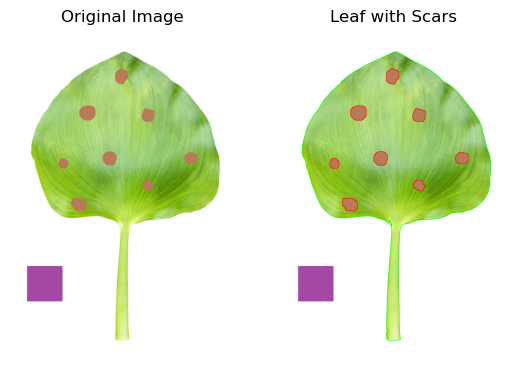

In [17]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Function to calculate the area in mm^2
def calculate_area(contour, scale):
    return cv2.contourArea(contour) * (scale ** 2)

# Function to calculate distance in mm
def calculate_length(points, scale):
    return cv2.arcLength(points, closed=False) * scale

# Load the image
image_path = 'Leaf-with-scars-1.png'
image = cv2.imread(image_path)

plt.subplot(1, 2, 1)
plt.title('Original Image')
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.axis('off')

# Convert the image to HSV color space
hsv_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

# Define color ranges for calibration cube (purple), leaf (green), and scars (brown)
purple_lower = np.array([120, 50, 50])
purple_upper = np.array([160, 255, 255])

green_lower = np.array([35, 40, 40])
green_upper = np.array([85, 255, 255])

brown_lower = np.array([10, 50, 50])
brown_upper = np.array([20, 255, 200])

# Create masks for the calibration cube, leaf, and scars
purple_mask = cv2.inRange(hsv_image, purple_lower, purple_upper)
green_mask = cv2.inRange(hsv_image, green_lower, green_upper)
brown_mask = cv2.inRange(hsv_image, brown_lower, brown_upper)

# Find contours of the calibration cube
cube_contours, _ = cv2.findContours(purple_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cube_contour = max(cube_contours, key=cv2.contourArea)

# Find contours of the leaf
leaf_contours, _ = cv2.findContours(green_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
leaf_contour = max(leaf_contours, key=cv2.contourArea)

# Find contours of the scars
scar_contours, _ = cv2.findContours(brown_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Get bounding box of the calibration cube and calculate the scale
x, y, w, h = cv2.boundingRect(cube_contour)
scale = 500 / w  # Assuming the cube is 500mm x 500mm

# Calculate leaf area in mm^2
leaf_area = calculate_area(leaf_contour, scale)

# Calculate scar areas in mm^2 and count the scars
scar_areas = [calculate_area(contour, scale) for contour in scar_contours]
scar_count = len(scar_areas)
total_scar_area = sum(scar_areas)

# Calculate percentage damage
percentage_damage = (total_scar_area / leaf_area) * 100

# Approximate the length of the petiole (assuming it's a straight line)
petiole_length = calculate_length(leaf_contour, scale)

# Print the results
print(f"Image: {image_path}")
# print(f"Calibration Scale: 1 pixel = {scale:.2f} mm")
print(f"Leaf Area: {leaf_area:.2f} mm^2")
print(f"Total Scar Area: {total_scar_area:.2f} mm^2")
print(f"Percentage Damage: {percentage_damage:.2f}%")
print(f"Number of Scars: {scar_count}")
print(f"Petiole Length: {petiole_length:.2f} mm")

# Optionally display the results visually
cv2.drawContours(image, [leaf_contour], -1, (0, 255, 0), 2)
cv2.drawContours(image, scar_contours, -1, (0, 0, 255), 2)
cv2.imshow("Leaf and Scars", image)
cv2.waitKey(0)
cv2.destroyAllWindows()

# Display the original and annotated images
plt.subplot(1, 2, 2)
plt.title('Leaf with Scars')
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.axis('off')

plt.show()


# Version 2
**Does not count scars that are not on the plant**

Image: Leaf-with-scars-12.png
Leaf Area: 5052479.03 mm^2
Total Scar Area: 767711.97 mm^2
Percentage Damage: 15.19%
Number of Scars: 18
Petiole Length: 12266.11 mm


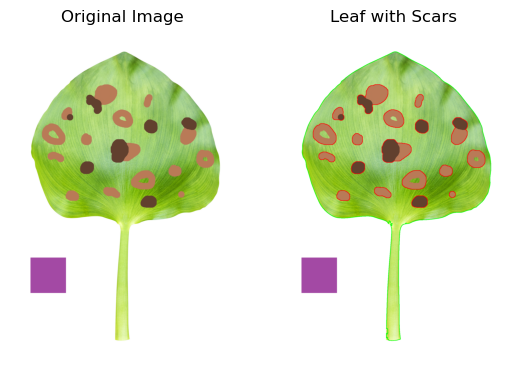

In [28]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Function to calculate the area in mm^2
def calculate_area(contour, scale):
    return cv2.contourArea(contour) * (scale ** 2)

# Function to calculate distance in mm
def calculate_length(points, scale):
    return cv2.arcLength(points, closed=False) * scale

# Load the image
image_path = "Leaf-with-scars-12.png"
image = cv2.imread(image_path)

plt.subplot(1, 2, 1)
plt.title('Original Image')
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.axis('off')

# Convert the image to HSV color space
hsv_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

# Define color ranges for calibration cube (purple), leaf (green), and scars (brown)
purple_lower = np.array([120, 50, 50])
purple_upper = np.array([160, 255, 255])

green_lower = np.array([35, 40, 40])
green_upper = np.array([85, 255, 255])

brown_lower = np.array([10, 50, 50])
brown_upper = np.array([20, 255, 200])

# Create masks for the calibration cube, leaf, and scars
purple_mask = cv2.inRange(hsv_image, purple_lower, purple_upper)
green_mask = cv2.inRange(hsv_image, green_lower, green_upper)
brown_mask = cv2.inRange(hsv_image, brown_lower, brown_upper)

# Find contours of the calibration cube
cube_contours, _ = cv2.findContours(purple_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cube_contour = max(cube_contours, key=cv2.contourArea)

# Find contours of the leaf
leaf_contours, _ = cv2.findContours(green_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
leaf_contour = max(leaf_contours, key=cv2.contourArea)

# Find contours of the scars
scar_contours, _ = cv2.findContours(brown_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Get bounding box of the calibration cube and calculate the scale
x, y, w, h = cv2.boundingRect(cube_contour)
scale = 500 / w  # Assuming the cube is 500mm x 500mm

# Calculate leaf area in mm^2
leaf_area = calculate_area(leaf_contour, scale)

# Filter out scars that are not on the leaf
valid_scar_contours = []
for contour in scar_contours:
    # Check if the center of the scar is inside the leaf contour
    M = cv2.moments(contour)
    if M['m00'] != 0:
        cx = int(M['m10'] / M['m00'])
        cy = int(M['m01'] / M['m00'])
        if cv2.pointPolygonTest(leaf_contour, (cx, cy), False) >= 0:
            valid_scar_contours.append(contour)

# Calculate scar areas in mm^2 and count the valid scars
scar_areas = [calculate_area(contour, scale) for contour in valid_scar_contours]
scar_count = len(scar_areas)
total_scar_area = sum(scar_areas)

# Calculate percentage damage
percentage_damage = (total_scar_area / leaf_area) * 100

# Approximate the length of the petiole (assuming it's a straight line)
petiole_length = calculate_length(leaf_contour, scale)

# Print the results
print(f"Image: {image_path}")
print(f"Leaf Area: {leaf_area:.2f} mm^2")
print(f"Total Scar Area: {total_scar_area:.2f} mm^2")
print(f"Percentage Damage: {percentage_damage:.2f}%")
print(f"Number of Scars: {scar_count}")
print(f"Petiole Length: {petiole_length:.2f} mm")

# Optionally display the results visually
cv2.drawContours(image, [leaf_contour], -1, (0, 255, 0), 2)
cv2.drawContours(image, valid_scar_contours, -1, (0, 0, 255), 2)
cv2.imshow("Leaf and Scars", image)
cv2.waitKey(0)
cv2.destroyAllWindows()

# Display the original and annotated images
plt.subplot(1, 2, 2)
plt.title('Leaf with Scars')
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.axis('off')

plt.show()
